In [10]:
!git clone https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer.git

Cloning into 'Image-Classification-Using-Vision-transformer'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 43 (delta 12), reused 8 (delta 8), pack-reused 29
Receiving objects: 100% (43/43), 862.14 KiB | 6.74 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [11]:
!unzip "/content/drive/MyDrive/archive (1).zip" -d "/content/Data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Data/archive (1)/Dataset/Train/Real/real_38398.jpg  
  inflating: /content/Data/archive (1)/Dataset/Train/Real/real_38399.jpg  
  inflating: /content/Data/archive (1)/Dataset/Train/Real/real_384.jpg  
  inflating: /content/Data/archive (1)/Dataset/Train/Real/real_3840.jpg  
  inflating: /content/Data/archive (1)/Dataset/Train/Real/real_38400.jpg  
  inflating: /content/Data/archive (1)/Dataset/Train/Real/real_38401.jpg  
  inflating: /content/Data/archive (1)/Dataset/Train/Real/real_38402.jpg  
  inflating: /content/Data/archive (1)/Dataset/Train/Real/real_38403.jpg  
  inflating: /content/Data/archive (1)/Dataset/Train/Real/real_38404.jpg  
  inflating: /content/Data/archive (1)/Dataset/Train/Real/real_38405.jpg  
  inflating: /content/Data/archive (1)/Dataset/Train/Real/real_38406.jpg  
  inflating: /content/Data/archive (1)/Dataset/Train/Real/real_38407.jpg  
  inflating: /content/Data/archive (1)/Dataset/Train

In [1]:

import torch
import torchvision

from torch import nn
from torchvision import transforms


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
class_names = ['real','fake']
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 94.2MB/s]


In [4]:
!pip install torchinfo

In [5]:
from torchinfo import summary
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), 
        col_names=["input_size"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]
├─Encoder (encoder)                                          [32, 197, 768]
│    └─Dropout (dropout)                                     [32, 197, 768]
│    └─Sequential (layers)                                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_3)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_4)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_5)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_6)                   [32, 197, 768]
│    │   

In [6]:
train_dir = "/content/Data/archive (1)/Dataset/Train"
test_dir = "/content/Data/archive (1)/Dataset/Test"

In [7]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [8]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  class_names = train_data.classes
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=0,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=0,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [12]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_vit.heads.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_vit.to(device)
num_epochs = 15
for epoch in range(num_epochs):
    pretrained_vit.train()  
    running_loss = 0.0
    for inputs, labels in tqdm(train_dataloader_pretrained, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_vit(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataloader_pretrained)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Training complete!")


Epoch 1/15:  20%|██        | 407/2014 [2:59:51<11:42:00, 26.21s/it]

In [ ]:
import torch
torch.save(pretrained_vit.state_dict(), '/content/drive/MyDrive/model.pth')

In [ ]:
import torch
import pickle
with open('/content/drive/MyDrive/pretrained_vit_model.pkl', 'wb') as f:
    pickle.dump(pretrained_vit, f)

print("Model saved successfully!")


Model saved successfully!


In [ ]:
with open('/content/drive/MyDrive/pretrained_vit_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
print("Model loaded successfully!")


Model loaded successfully!


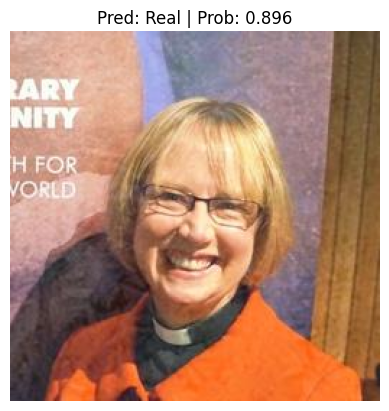

In [ ]:
from going_modular.going_modular.predictions import pred_and_plot_image
custom_image_path = "/content/Data/archive (1)/Dataset/Test/Real/real_1.jpg"
pred_and_plot_image(model=loaded_model,
                    image_path=custom_image_path,
                    class_names=class_names)